Let's see if LSI, a common dimensionality reduction method in NLP, can give us any interesting results.

In [15]:
from gensim.models import LsiModel
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
from go_learning_helpers import *
import matplotlib.pyplot as plt
import scipy.sparse as sp
%matplotlib notebook

In [16]:
file_name = 'kinase_go_processes.csv'
path_to_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(path_to_dir+file_name)

In [31]:
'''# binarize
lb, go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)'''

'# binarize\nlb, go_annotations = convert_go_annotations_to_one_hot(go_annotations,\n                                                   return_binarizer= True)'

In [17]:
from collections import defaultdict
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1

texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

In [18]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
#dictionary.save('./go.dict')
print(dictionary)

Dictionary(1370 unique tokens: ['canonical glycolysis', 'cellular response to hypoxia', 'chemical synaptic transmission', 'epithelial cell differentiation', 'gluconeogenesis']...)


In [19]:
corpus = [dictionary.doc2bow(doc) for doc in texts]
#corpora.MmCorpus.serialize('./go.mm', corpus)

In [20]:
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus)

In [21]:
corpus_tfidf = tfidf[corpus]

In [8]:
'''id_dict = {}
for x in range(len(go_annotations)):
    one_hot_array = np.zeros((len(go_annotations),1))
    one_hot_array.itemset(x, 1)
    id_dict[x] = lb.inverse_transform(one_hot_array)'''

'id_dict = {}\nfor x in range(len(go_annotations)):\n    one_hot_array = np.zeros((len(go_annotations),1))\n    one_hot_array.itemset(x, 1)\n    id_dict[x] = lb.inverse_transform(one_hot_array)'

In [22]:
# binarize
lb, binarized_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

go_matrix = np.vstack([x for x in binarized_go_annotations])
go_sparse = sp.csc_matrix(go_matrix.T)

In [23]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components =3)

tsvd.fit(go_matrix.T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [24]:
a, b = map(np.asarray, zip(*corpus_tfidf[10]))
row = np.repeat(0, len(a))
print(row)
print(a)
print(b)

[0 0 0 0 0 0 0]
[ 15  73 191 192 193 194 195]
[0.17951479 0.15908187 0.23956078 0.4413603  0.4413603  0.51152778
 0.4835489 ]


In [25]:
len(dictionary)

1370

In [26]:
sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))

<1x1370 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Column format>

In [27]:
hold = []
for i in range(473):
    if(len(corpus_tfidf[i]) > 0):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        print(i)

337


In [28]:
tsvd.fit(sp.vstack(hold).toarray().T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [29]:
tsvd.explained_variance_ratio_

array([0.01808293, 0.01683751, 0.01363217])

In [30]:
mod = LsiModel(corpus=corpus_tfidf, num_topics=2, id2word=dictionary)

In [31]:
mod.print_topics(2)

[(0,
  '0.220*"intracellular signal transduction" + 0.203*"signal transduction by protein phosphorylation" + 0.200*"stress-activated protein kinase signaling cascade" + 0.195*"activation of protein kinase activity" + 0.192*"peptidyl-tyrosine phosphorylation" + 0.189*"DNA-templated" + 0.186*"protein autophosphorylation" + 0.184*"peptidyl-serine phosphorylation" + 0.164*"MAPK cascade" + 0.161*"negative regulation of apoptotic process"'),
 (1,
  '-0.305*"stress-activated protein kinase signaling cascade" + -0.297*"signal transduction by protein phosphorylation" + -0.280*"activation of protein kinase activity" + 0.273*"negative regulation of signal transduction" + 0.265*"cell differentiation" + 0.246*"peptidyl-tyrosine phosphorylation" + 0.241*"positive regulation of ERK1 and ERK2 cascade" + 0.197*"negative regulation of apoptotic process" + -0.170*"activation of JUN kinase activity" + 0.168*"ephrin receptor signaling pathway"')]

In [32]:
corpus_lsi = mod[corpus_tfidf]

In [33]:
corpus_lsi.obj.show_topics(2)

[(0,
  '0.220*"intracellular signal transduction" + 0.203*"signal transduction by protein phosphorylation" + 0.200*"stress-activated protein kinase signaling cascade" + 0.195*"activation of protein kinase activity" + 0.192*"peptidyl-tyrosine phosphorylation" + 0.189*"DNA-templated" + 0.186*"protein autophosphorylation" + 0.184*"peptidyl-serine phosphorylation" + 0.164*"MAPK cascade" + 0.161*"negative regulation of apoptotic process"'),
 (1,
  '-0.305*"stress-activated protein kinase signaling cascade" + -0.297*"signal transduction by protein phosphorylation" + -0.280*"activation of protein kinase activity" + 0.273*"negative regulation of signal transduction" + 0.265*"cell differentiation" + 0.246*"peptidyl-tyrosine phosphorylation" + 0.241*"positive regulation of ERK1 and ERK2 cascade" + 0.197*"negative regulation of apoptotic process" + -0.170*"activation of JUN kinase activity" + 0.168*"ephrin receptor signaling pathway"')]

<IPython.core.display.Javascript object>


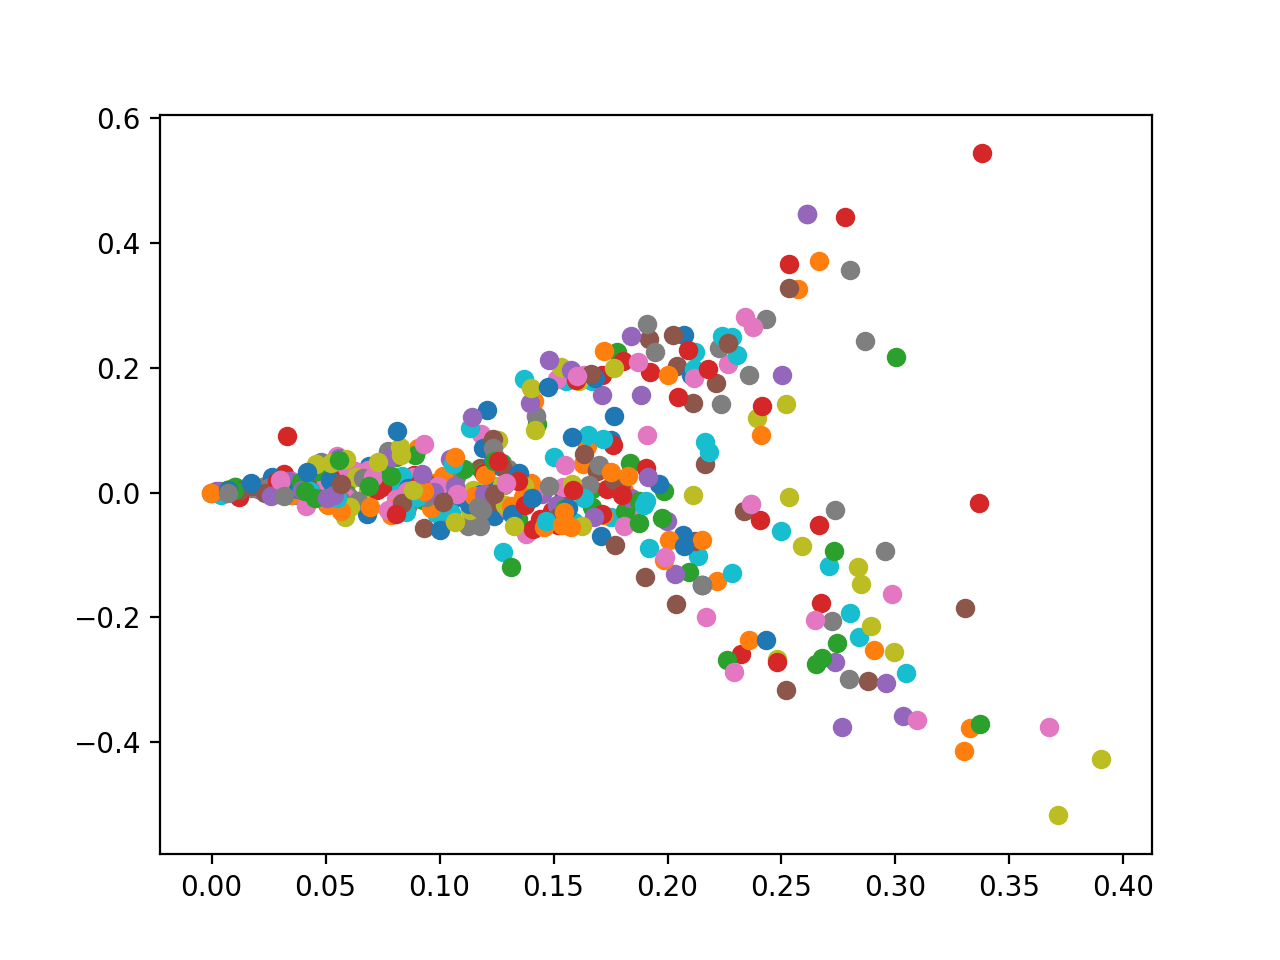

337


In [34]:
fig, ax = plt.subplots()
for i in range(473):
    try:
        ax.scatter(x=corpus_lsi[i][0][1], y = corpus_lsi[i][1][1])
    except:
        print(i)

In [35]:
mod_3 = LsiModel(corpus=corpus_tfidf, num_topics=3, id2word=dictionary)

In [36]:
corpus_lsi_3 = mod_3[corpus_tfidf]

In [37]:
corpus_lsi_3.obj.show_topics(3)

[(0,
  '0.220*"intracellular signal transduction" + 0.203*"signal transduction by protein phosphorylation" + 0.200*"stress-activated protein kinase signaling cascade" + 0.195*"activation of protein kinase activity" + 0.192*"peptidyl-tyrosine phosphorylation" + 0.189*"DNA-templated" + 0.185*"protein autophosphorylation" + 0.184*"peptidyl-serine phosphorylation" + 0.164*"MAPK cascade" + 0.162*"negative regulation of apoptotic process"'),
 (1,
  '0.306*"stress-activated protein kinase signaling cascade" + 0.298*"signal transduction by protein phosphorylation" + 0.280*"activation of protein kinase activity" + -0.272*"negative regulation of signal transduction" + -0.265*"cell differentiation" + -0.248*"peptidyl-tyrosine phosphorylation" + -0.240*"positive regulation of ERK1 and ERK2 cascade" + -0.198*"negative regulation of apoptotic process" + 0.169*"activation of JUN kinase activity" + -0.168*"ephrin receptor signaling pathway"'),
 (2,
  '-0.331*"peptidyl-serine phosphorylation" + -0.313*

<IPython.core.display.Javascript object>


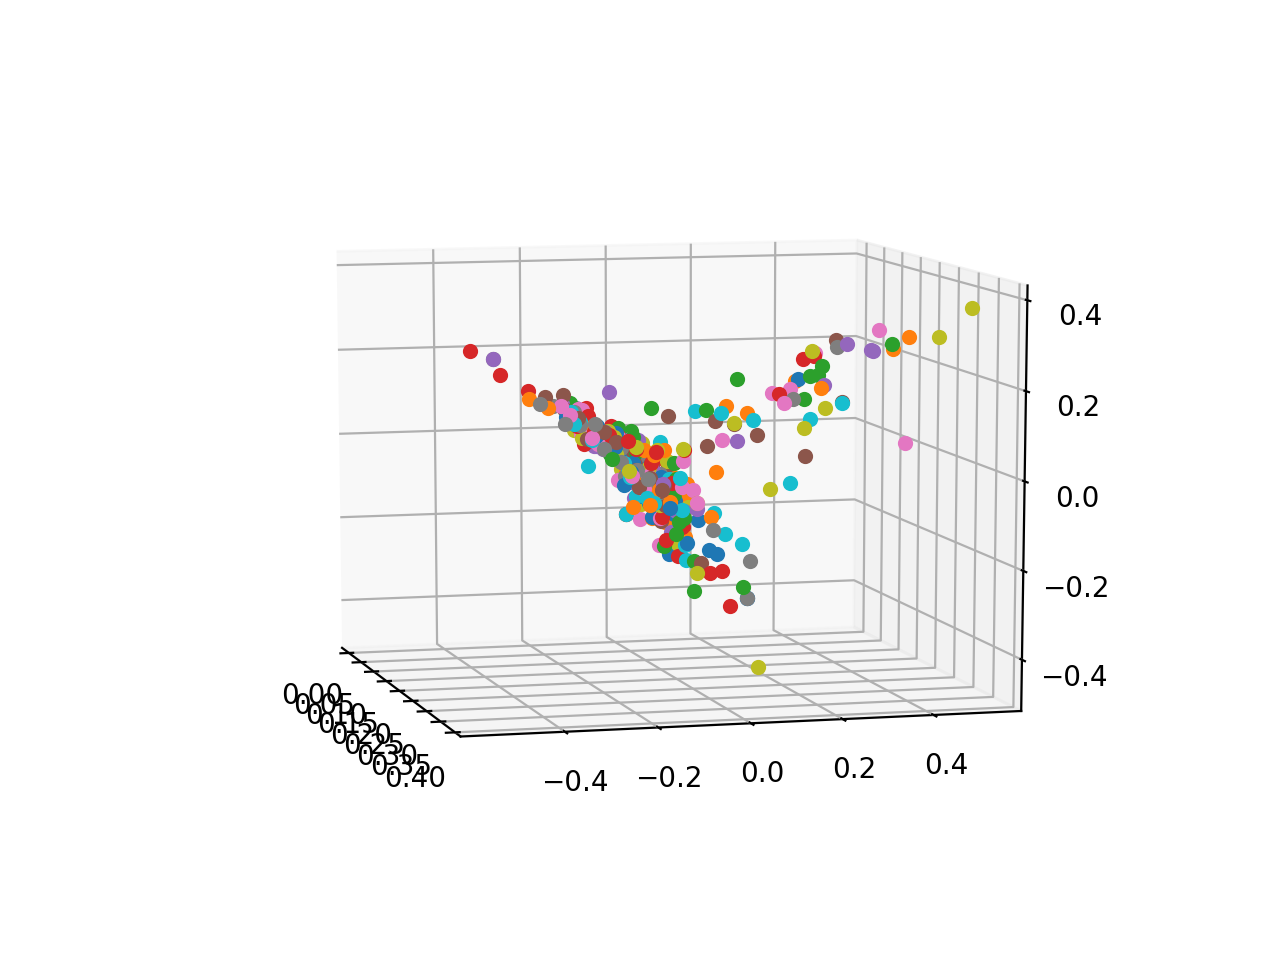

337


In [38]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(473):
    try:
        ax.scatter(corpus_lsi_3[i][0][1], corpus_lsi_3[i][1][1], corpus_lsi_3[i][2][1])
    except:
        print(i)

In [39]:
ind = go_annotations.index.tolist()

In [40]:
corpus_lsi_3[0]

[(0, 0.0321582102847724),
 (1, -0.021367581397599564),
 (2, -0.002919788573940922)]

In [41]:
consensus_file_name = 'consensusclusters_spinglass_greaterthan90percent.txt'
path_to_consensus = '../reproduced/'

consensus_dat = add_cluster_labels(path_to_consensus+consensus_file_name,
                                  go_annotations)

print(consensus_dat.head(5))

Dropped  0 kinases due to zero length post-processing
       cluster                                          GO Labels
names                                                            
PAK1         1  [positive regulation of JUN kinase activity, n...
ERBB2        2  [peptidyl-tyrosine phosphorylation, negative r...
RON          3  [positive regulation of MAP kinase activity, p...
YES          3  [cellular protein modification process, Fc-gam...
TYRO3        3  [viral entry into host cell, peptidyl-tyrosine...


In [42]:
x_coords = [corpus_lsi_3[x][0][1] for x in range(473) if len(corpus_lsi_3[x])>1]
y_coords = [corpus_lsi_3[x][1][1] for x in range(473) if len(corpus_lsi_3[x])>1]
z_coords = [corpus_lsi_3[x][2][1] for x in range(473) if len(corpus_lsi_3[x])>1]

In [43]:
colors = [consensus_dat['cluster'].loc[ind[x]] for x in range(473) if x != 337]

<IPython.core.display.Javascript object>


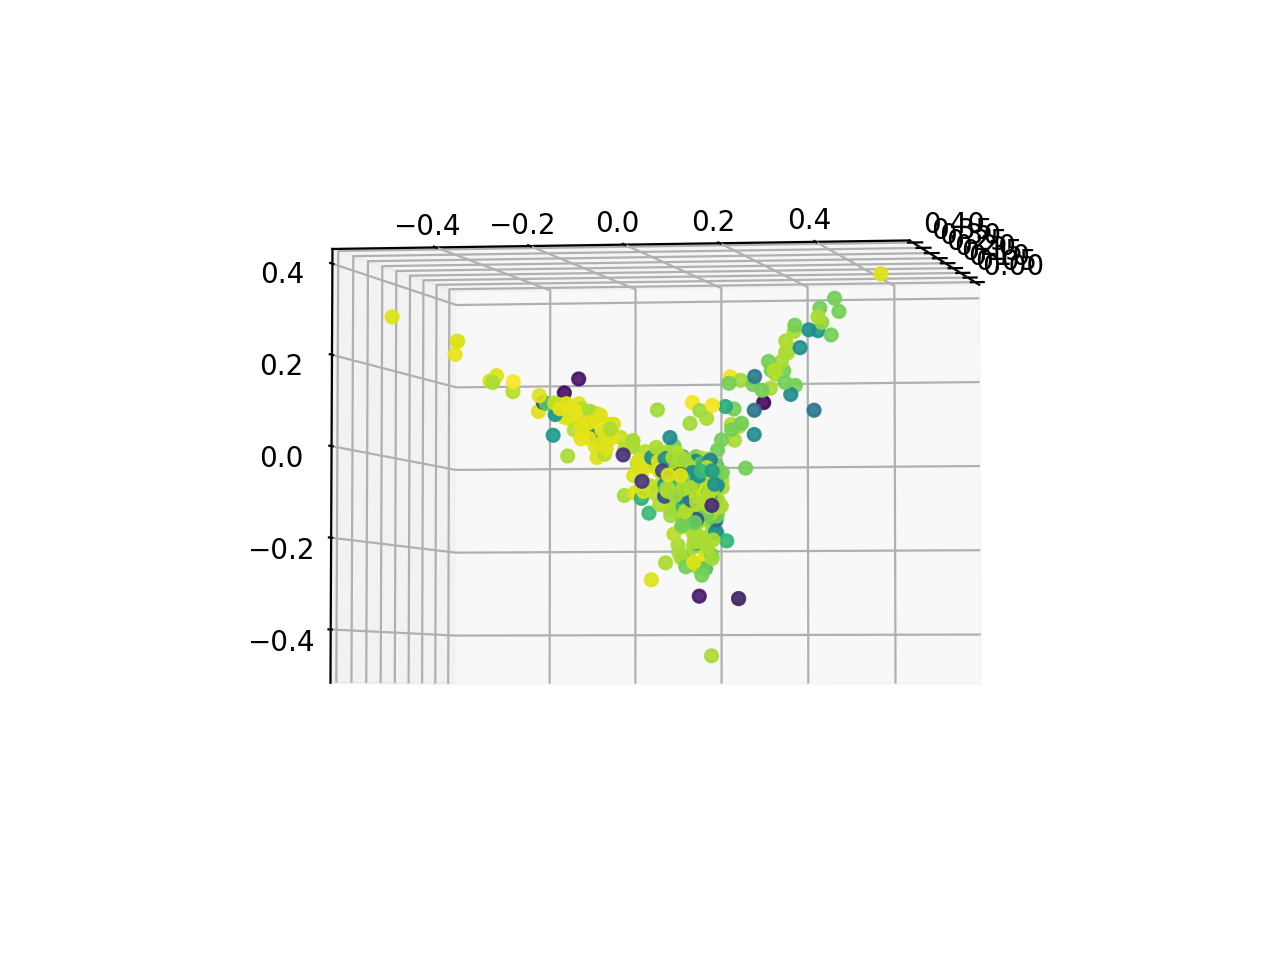

In [44]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='viridis_r')

In [45]:
fast_greedy_file_name = 'fastgreedy_clusters.txt'
path_to_fast_greedy = '../reproduced/'

fast_greedy_dat = add_cluster_labels(path_to_fast_greedy+fast_greedy_file_name,
                                  go_annotations)

print(fast_greedy_dat.head(5))

Dropped  0 kinases due to zero length post-processing
       cluster                                          GO Labels
names                                                            
PAK1         3  [positive regulation of JUN kinase activity, n...
ERBB2        3  [peptidyl-tyrosine phosphorylation, negative r...
RON          6  [positive regulation of MAP kinase activity, p...
YES          6  [cellular protein modification process, Fc-gam...
TYRO3        6  [viral entry into host cell, peptidyl-tyrosine...


In [47]:
colors = [fast_greedy_dat['cluster'].loc[ind[x]] for x in range(473) if x != 337]

<IPython.core.display.Javascript object>


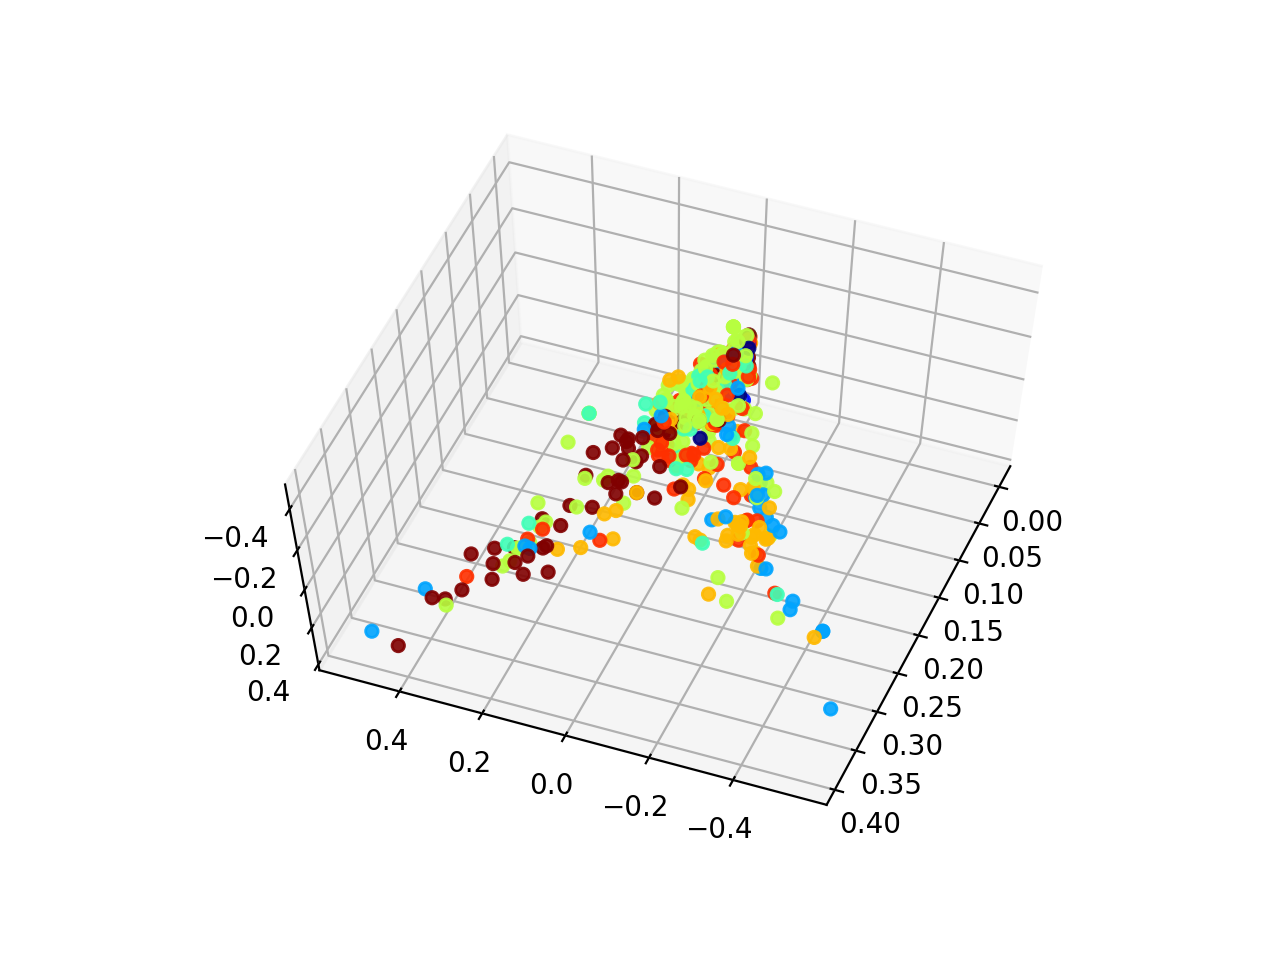

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

In [49]:
lsi_dat = pd.DataFrame(np.vstack([np.asarray(x_coords).reshape(1,472),np.asarray(y_coords).reshape(1,472), np.asarray(z_coords).reshape(1,472)]).T)

In [50]:
lsi_dat.index = [y for x, y in enumerate(ind) if x != 163]

In [51]:
lsi_dat.head()

,0,1,2
PGK1,0.032158,-0.021368,-0.002920
CDKL1,0.046289,-0.012079,-0.111838
KC1G3,0.166724,-0.005519,-0.217657
NEK10,0.031862,-0.030757,0.019747
TTK,0.123413,-0.048361,-0.081218


In [52]:
consensus_file_name = 'consensusclusters_spinglass_greaterthan90percent.txt'
path_to_consensus = '../reproduced/'

consensus_lsi = add_cluster_labels(path_to_consensus+consensus_file_name,
                                  lsi_dat)

print(consensus_lsi.head(5))
consensus_lsi.dropna(inplace=True, axis=0)

Dropped  1 kinases due to zero length post-processing
       cluster         0         1         2
names                                       
PAK1         1  0.390524  0.427720  0.315962
ERBB2        2  0.235596 -0.188308  0.036743
RON          3  0.242886 -0.278013  0.098381
YES          3  0.151909 -0.182377  0.070336
TYRO3        3  0.176849 -0.197195  0.043298


In [53]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear')
nb = GNB()
#cnb = CNB()

classifiers = [svm, nb]#, cnb]

In [54]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(consensus_lsi[[0,1,2]].values.tolist(), consensus_lsi['cluster'].values.tolist(), test_size=0.3)

for clf in classifiers:
    clf.fit(X_train, y_train);

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test)))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'matthews'))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'cohen'))

0.2746478873239437
0.2323943661971831
0.06997282104449117
0.08772007944384755
0.030170413102579396
0.08207804530897866


In [55]:
fast_greedy_file_name = 'fastgreedy_clusters.txt'
path_to_fast_greedy = '../reproduced/'

fast_greedy_lsi = add_cluster_labels(path_to_fast_greedy+fast_greedy_file_name,
                                  lsi_dat)

fast_greedy_lsi.dropna(inplace=True, axis=0)
print(fast_greedy_lsi.head(5))

Dropped  1 kinases due to zero length post-processing
       cluster         0         1         2
names                                       
PAK1         3  0.390524  0.427720  0.315962
ERBB2        3  0.235596 -0.188308  0.036743
RON          6  0.242886 -0.278013  0.098381
YES          6  0.151909 -0.182377  0.070336
TYRO3        6  0.176849 -0.197195  0.043298


In [56]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(fast_greedy_lsi[[0,1,2]].values.tolist(), fast_greedy_lsi['cluster'].values.tolist(), test_size=0.3)

for clf in classifiers:
    clf.fit(X_train, y_train);

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test)))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'matthews'))

for clf in classifiers:
    print(score_model(y_test, clf.predict(X_test), 'cohen'))

0.31690140845070425
0.30985915492957744
0.0
0.045669130770016164
0.0
0.03361111111111115


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [57]:
mod_50 = LsiModel(corpus=corpus_tfidf, num_topics=50, id2word=dictionary)

In [58]:
corpus_lsi_50 = mod_50[corpus_tfidf]

In [59]:
from sklearn.manifold import TSNE

t = TSNE(n_components=3)

In [60]:
corpus_lsi_50[1][48][1]

0.095726570483363

In [61]:
holder = []
for x in range(473):
    if(len(corpus_lsi_50[x])>1):
        holder.append([corpus_lsi_50[x][i][1] for i in range(50)])

In [62]:
np.vstack(map(np.array, holder)).shape

(472, 50)

In [64]:
new_dat = t.fit_transform(np.vstack(map(np.array, holder)))

In [65]:
x_coords = [coord[0] for coord in new_dat]
y_coords = [coord[1] for coord in new_dat]
z_coords = [coord[2] for coord in new_dat]

In [66]:
colors = [fast_greedy_dat['cluster'].loc[ind[x]] for x in range(473) if x != 337]

<IPython.core.display.Javascript object>


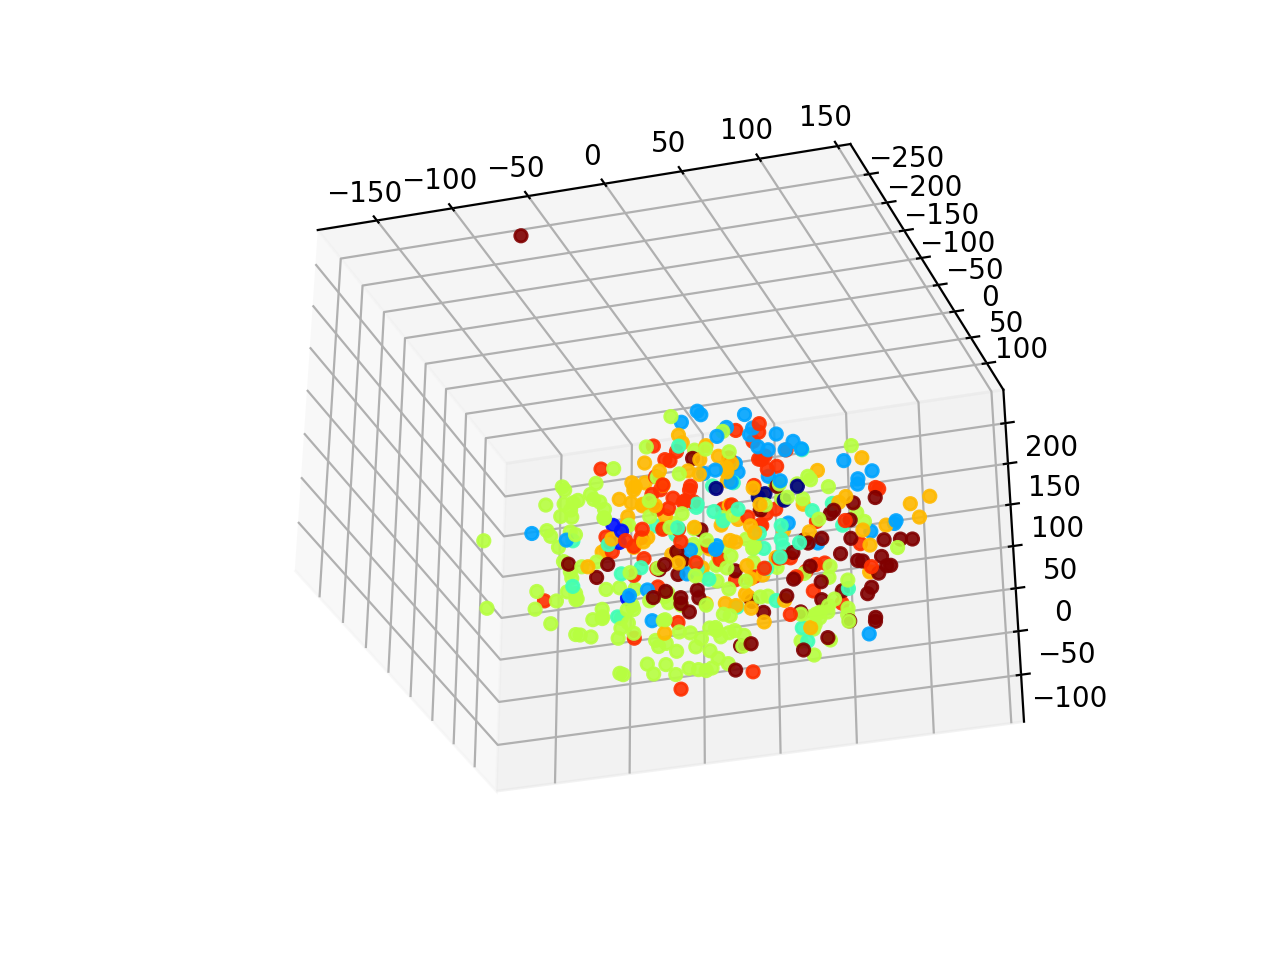

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')

In [68]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=3)

In [69]:
new_dat_iso = iso.fit_transform(np.vstack(map(np.array, holder)))

In [70]:
x_coords = [coord[0] for coord in new_dat_iso]
y_coords = [coord[1] for coord in new_dat_iso]
z_coords = [coord[2] for coord in new_dat_iso]

<IPython.core.display.Javascript object>


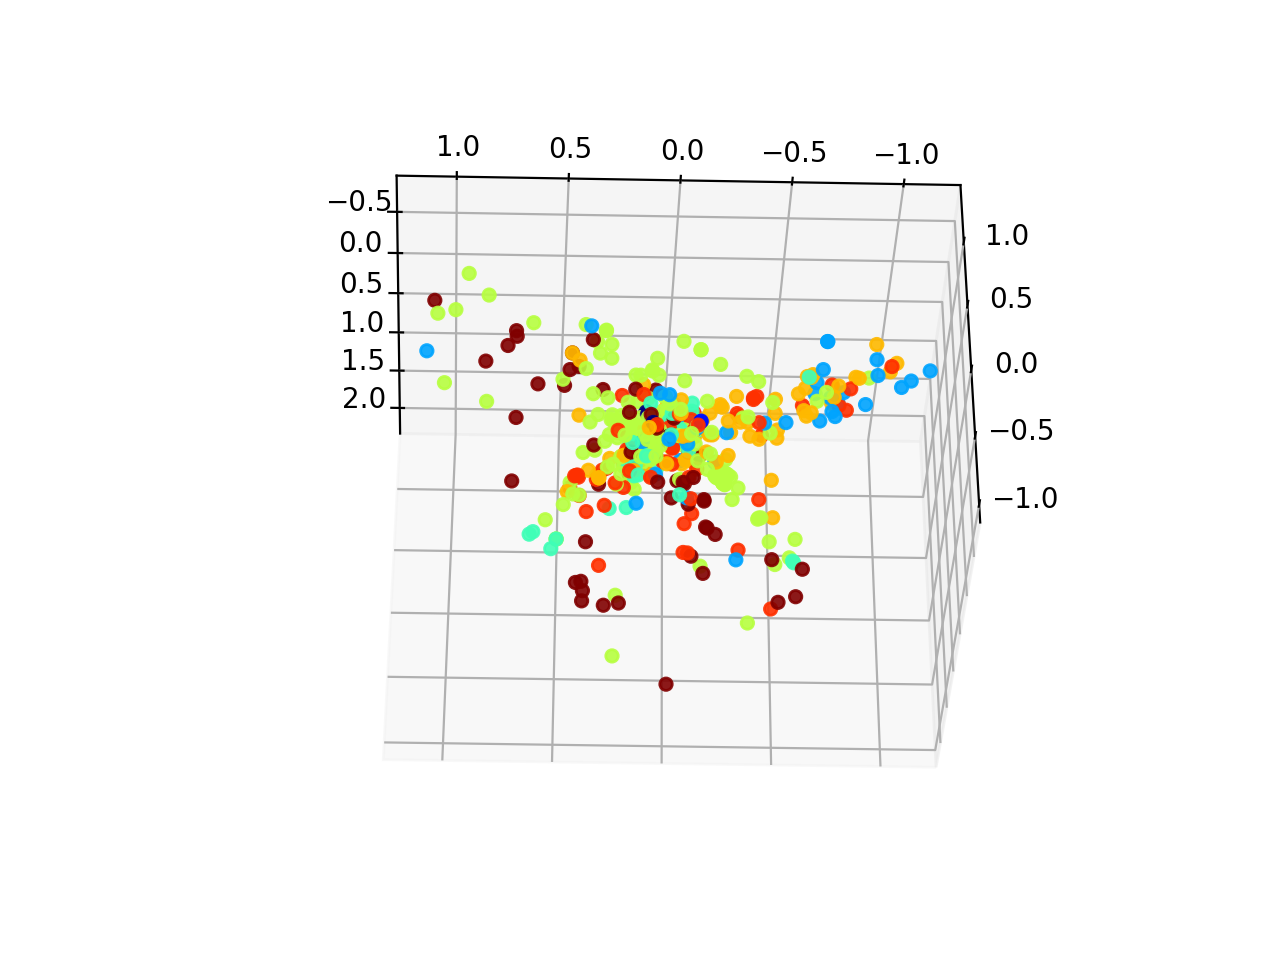

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, alpha = 0.9, c=colors, cmap='jet_r')